# Objetivo

Este notebook tiene como objetivo desarrollar y evaluar un modelo de red neuronal para predecir si un estudiante ha sufrido bullying o no, a partir de variables categóricas relacionadas con su entorno escolar, social y familiar.

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn import datasets

In [ ]:
df = pd.read_csv("Bullying_2018.csv", sep=";")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56981 entries, 0 to 56980
Data columns (total 18 columns):
 #   Column                                            Non-Null Count  Dtype 
---  ------                                            --------------  ----- 
 0   record                                            56981 non-null  int64 
 1   Bullied_on_school_property_in_past_12_months      56981 non-null  object
 2   Bullied_not_on_school_property_in_past_12_months  56981 non-null  object
 3   Cyber_bullied_in_past_12_months                   56981 non-null  object
 4   Custom_Age                                        56981 non-null  object
 5   Sex                                               56981 non-null  object
 6   Physically_attacked                               56981 non-null  object
 7   Physical_fighting                                 56981 non-null  object
 8   Felt_lonely                                       56981 non-null  object
 9   Close_friends               

# Creación de la variable objetivo: *Bullied*

Es necesario definir una variable objetivo binaria que indique si un estudiante ha sido víctima de bullying.  

En este caso, se construyó la variable *Bullied* a partir de tres indicadores disponibles:

- Bullied_on_school_property_in_past_12_months
- Bullied_not_on_school_property_in_past_12_months
- Cyber_bullied_in_past_12_months

In [ ]:
df["Bullied"] = df[["Bullied_on_school_property_in_past_12_months",
                    "Bullied_not_on_school_property_in_past_12_months",
                    "Cyber_bullied_in_past_12_months"
                  ]].eq("Yes").any(axis=1).map({True: "Yes", False: "No"})
print(df.shape)
df.head()

(56981, 19)


,record,Bullied_on_school_property_in_past_12_months,Bullied_not_on_school_property_in_past_12_months,Cyber_bullied_in_past_12_months,Custom_Age,Sex,Physically_attacked,Physical_fighting,Felt_lonely,Close_friends,Miss_school_no_permission,Other_students_kind_and_helpful,Parents_understand_problems,Most_of_the_time_or_always_felt_lonely,Missed_classes_or_school_without_permission,Were_underweight,Were_overweight,Were_obese,Bullied
0,1,Yes,Yes,,13 years old,Female,0 times,0 times,Always,2,10 or more days,Never,Always,Yes,Yes,,,,Yes
1,2,No,No,No,13 years old,Female,0 times,0 times,Never,3 or more,0 days,Sometimes,Always,No,No,,,,No
2,3,No,No,No,14 years old,Male,0 times,0 times,Never,3 or more,0 days,Sometimes,Always,No,No,No,No,No,No
3,4,No,No,No,16 years old,Male,0 times,2 or 3 times,Never,3 or more,0 days,Sometimes,,No,No,No,No,No,No
4,5,No,No,No,13 years old,Female,0 times,0 times,Rarely,3 or more,0 days,Most of the time,Most of the time,No,No,,,,No


# Limpieza de los datos

In [ ]:
# Eliminar registros inconsistentes
df = df[~df["Custom_Age"].isin(["11 years old or younger", "12 years old", "18 years old or older"])]

# Eliminar columnas que no aportan un peso significativo
df = df.drop(['record', 'Were_underweight', 'Were_overweight', 'Were_obese'], axis=1)

In [ ]:
# Detectar celdas que son cadena vacía o solo espacios
espacios = df.map(lambda x: isinstance(x, str) and x.strip() == "")

# Contar espacios por columna
conteo_espacios = espacios.sum()

# Eliminar filas donde al menos una columna tenga espacios
df = df[~espacios.any(axis=1)]

print("Filas/Columnas:", df.shape)

Filas/Columnas: (50268, 15)


In [ ]:
# Depuración de variables

df = df.drop(['Missed_classes_or_school_without_permission',
              'Most_of_the_time_or_always_felt_lonely',
              'Bullied_on_school_property_in_past_12_months',
              'Bullied_not_on_school_property_in_past_12_months',
              'Cyber_bullied_in_past_12_months'
         ], axis=1)

# Codificación de variables categóricas con One-Hot Encoding

In [ ]:
df = pd.get_dummies(df, drop_first=True)
print("Filas/Columnas:", df.shape)

Filas/Columnas: (50268, 39)


# Definición de variables predictoras y objetivo

In [ ]:
X = df.drop('Bullied_Yes', axis=1)
y = df['Bullied_Yes']

# Separación de los datos en entrenamiento y prueba

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Cantidad de datos de entrenamiento

In [ ]:
print(f"Cantidad de datos de entrenamiento: {X_train.shape}")

Cantidad de datos de entrenamiento: (40214, 38)


# Diseño de la red neuronal

## Inicialización del modelo

In [ ]:
model = tf.keras.models.Sequential()

## Construcción del modelo

In [ ]:
# Primera capa
model.add(tf.keras.layers.Dense(64, activation=tf.nn.sigmoid, input_shape=(X.shape[1],)))

# Capas ocultas
model.add(tf.keras.layers.Dense(32, activation=tf.nn.sigmoid))
model.add(tf.keras.layers.Dense(16, activation=tf.nn.sigmoid))

# Capa de salida
model.add(tf.keras.layers.Dense(1, activation=tf.nn.sigmoid))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
optim = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [ ]:
model.compile(
    loss='binary_crossentropy',
    optimizer=optim,metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 64)             │         2,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,121 (20.00 KB)

 Trainable params: 5,121 (20.00 KB)

 Non-trainable params: 0 (0.00 B)

## Ajuste en los pesos y entrenamiento del modelo

In [ ]:
classes = np.array([0,1])
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight = {0: weights[0], 1: weights[1]}
print(class_weight)

# Entrenamiento del modelo
history = model.fit(X_train, y_train,
        validation_data=(X_test, y_test),
        epochs = 5,
        batch_size=32,
        class_weight=class_weight)

{0: np.float64(0.832071177322574), 1: np.float64(1.2528506448999939)}
Epoch 1/5
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4385 - loss: 0.7028 - val_accuracy: 0.6235 - val_loss: 0.6847
Epoch 2/5
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5868 - loss: 0.6876 - val_accuracy: 0.6457 - val_loss: 0.6786
Epoch 3/5
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6252 - loss: 0.6756 - val_accuracy: 0.6499 - val_loss: 0.6547
Epoch 4/5
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6306 - loss: 0.6544 - val_accuracy: 0.6453 - val_loss: 0.6425
Epoch 5/5
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6393 - loss: 0.6419 - val_accuracy: 0.6539 - val_loss: 0.6295


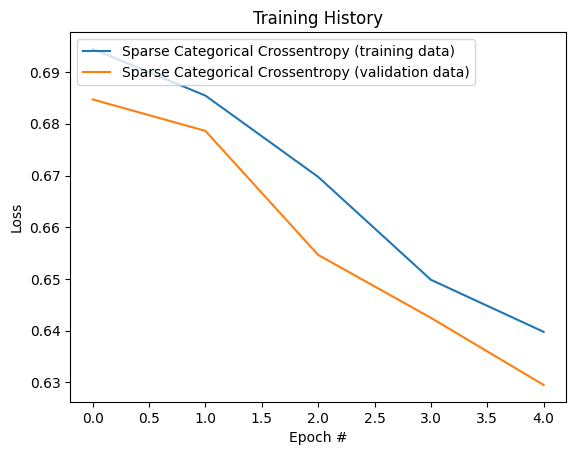

In [ ]:
plt.plot(history.history['loss'], label='Sparse Categorical Crossentropy (training data)')
plt.plot(history.history['val_loss'], label='Sparse Categorical Crossentropy (validation data)')
plt.title('Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch #')
plt.legend(loc="upper left")
plt.show()

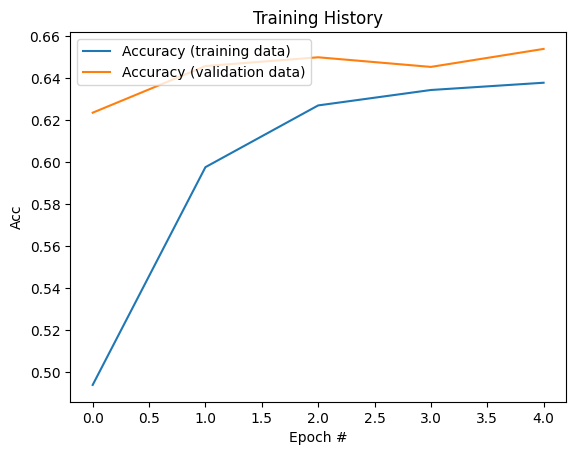

In [ ]:
plt.plot(history.history['accuracy'], label='Accuracy (training data)')
plt.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
plt.title('Training History')
plt.ylabel('Acc')
plt.xlabel('Epoch #')
plt.legend(loc="upper left")
plt.show()

In [ ]:
y_pred_proba = model.predict(X_test)

if y_pred_proba.ndim == 2 and y_pred_proba.shape[1] > 1:
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = np.argmax(y_test, axis=1) if (hasattr(y_test, "ndim") and y_test.ndim == 2 and y_test.shape[1] > 1) else y_test
    average = "weighted"
else:
    y_pred = (y_pred_proba > 0.5).astype(int).ravel()
    if hasattr(y_test, "ndim") and y_test.ndim == 2 and y_test.shape[1] > 1:
        y_true = np.argmax(y_test, axis=1)
    else:
        y_true = np.ravel(y_test).astype(int)
    average = "binary"

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average=average, zero_division=0)
rec  = recall_score(y_true, y_pred, average=average, zero_division=0)
cm   = confusion_matrix(y_true, y_pred)

print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)

print("\nReporte de clasificación:\n", classification_report(y_true, y_pred, zero_division=0))


315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy : 0.6538691068231549
Precision: 0.5536159600997507
Recall   : 0.6177586643055907

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.73      0.68      0.70      6101
           1       0.55      0.62      0.58      3953

    accuracy                           0.65     10054
   macro avg       0.64      0.65      0.64     10054
weighted avg       0.66      0.65      0.66     10054



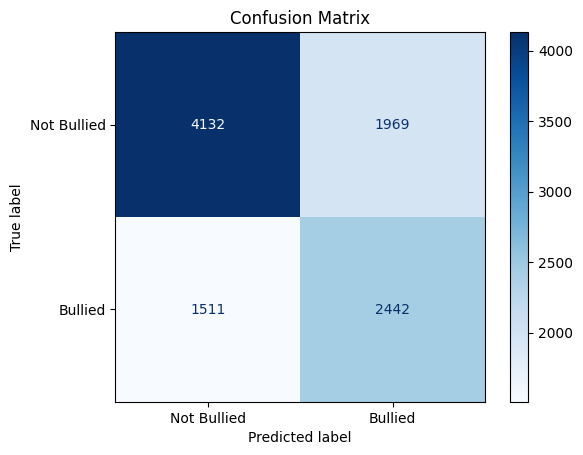

Classification Report:
              precision    recall  f1-score   support

 Not Bullied       0.73      0.68      0.70      6101
     Bullied       0.55      0.62      0.58      3953

    accuracy                           0.65     10054
   macro avg       0.64      0.65      0.64     10054
weighted avg       0.66      0.65      0.66     10054



In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Bullied", "Bullied"])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()


print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Not Bullied", "Bullied"]))